# HW12
## Making a Semivariogram based on asthma dismissal records

#### Importing packages

In [199]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import pylab as pl
import zipfile
import os
import seaborn
import math
from scipy.spatial.distance import pdist, squareform
%matplotlib inline

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

#### Getting data through SQL query

In [24]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = '''
SELECT 
COUNT (*) as count,
zipcodes
FROM NYCAsthmasDismissals
GROUP BY zipcodes
'''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


#### Downloading and unzipping shapefiles 

In [25]:
# Downloading zip shapefile
!curl -O 'https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1478k  100 1478k    0     0  1001k      0  0:00:01  0:00:01 --:--:-- 1282k


In [27]:
# unzipping to PUIDATA
zip_path = 'YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall(os.getenv('PUIDATA'))
zip_ref.close()

#### Import shapefile and merge with asthma dismissal data 

In [210]:
# importing shapefile
shapefile = gpd.read_file(os.getenv('PUIDATA') + '/ZIP_CODE_040114.shp')

In [211]:
# setting coordinate system
shapefile = shapefile.to_crs(epsg=32118)

In [212]:
shapefile.head(3)

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((316412.979996387 57344.69291911653, ..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((305292.4702963857 56975.29271911704,..."
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((308206.535596385 55990.75571911522, ..."


In [213]:
# checking merge columns
print type(facilities.zipcodes[0])
print type (shapefile.ZIPCODE[0])

<type 'numpy.int64'>
<type 'unicode'>


In [214]:
shapefile['ZIPCODE'] = shapefile['ZIPCODE'].astype(int)

In [215]:
#dropping uneeded columns
shapefile.drop(['AREA', 'BLDGZIP', 'COUNTY', 'CTY_FIPS', 'POPULATION', 'PO_NAME', 'SHAPE_AREA', 
               'SHAPE_LEN', 'STATE', 'ST_FIPS', 'URL'], axis=1, inplace=True)

In [216]:
# renaming merge columns
shapefile.rename(columns={'ZIPCODE' : 'zipcodes'}, inplace=True)

In [217]:
# merging
merged = pd.merge(left=facilities, right=shapefile, on='zipcodes', how='left')

#### Setting up geodataframe and retrieving information of importance 

In [218]:
# changing from dataframe to geodataframe
merged = gpd.GeoDataFrame(merged)

In [219]:
# changing geometry to point
merged['geometry']=merged.geometry.centroid

In [220]:
type(merged)

geopandas.geodataframe.GeoDataFrame

In [222]:
merged.head()

,count,zipcodes,geometry
0,1699,10461,POINT (313424.2492385742 75560.81126467389)
1,405,11373,POINT (310269.1030166568 63546.38699870969)
2,1698,10451,POINT (306434.0242675035 72638.88266038348)
3,220,11691,POINT (320150.6037198587 48230.2654135345)
4,246,11375,POINT (312987.0073014591 61533.21518736489)


In [223]:
# fuctions to retrieve the x- and y coordinates respectively
def getX(pt):
    return pt.x
def getY(pt):
    return pt.y

In [224]:
centroidlist_x=map(getX,merged['geometry'].centroid)
centroidlist_y=map(getY,merged['geometry'].centroid)

#### Creating a 3xN numpy array with x-location, y-location, number of dismissals to map and create semi-variogram

In [225]:
krigdata = np.zeros((len(merged),3))

In [226]:
# filling in the krigdata array
krigdata[:,2] = merged['count']
for i in range(len(krigdata)):
    krigdata[:,0][i] = centroidlist_x[i]
    krigdata[:,1][i] = centroidlist_y[i]

In [227]:
krigdata

array([[  3.13424249e+05,   7.55608113e+04,   1.69900000e+03],
       [  3.10269103e+05,   6.35463870e+04,   4.05000000e+02],
       [  3.06434024e+05,   7.26388827e+04,   1.69800000e+03],
       [  3.20150604e+05,   4.82302654e+04,   2.20000000e+02],
       [  3.12987007e+05,   6.15332152e+04,   2.46000000e+02],
       [  3.12922666e+05,   8.04397124e+04,   4.94000000e+02],
       [  3.07350381e+05,   5.50984846e+04,   7.13000000e+02],
       [  3.04713523e+05,   4.82466810e+04,   1.67000000e+02],
       [  3.01709066e+05,   5.54035954e+04,   5.21000000e+02],
       [  2.98583801e+05,   5.26929596e+04,   3.86000000e+02],
       [  3.15088229e+05,   6.49302856e+04,   6.41000000e+02],
       [  3.05383654e+05,   5.60233009e+04,   3.76000000e+02],
       [  3.14177231e+05,   5.90455709e+04,   5.67000000e+02],
       [  2.90217216e+05,   5.18302910e+04,   4.11000000e+02],
       [  3.05558464e+05,   5.36351308e+04,   1.82900000e+03],
       [  3.06206507e+05,   6.71761404e+04,   2.8100000

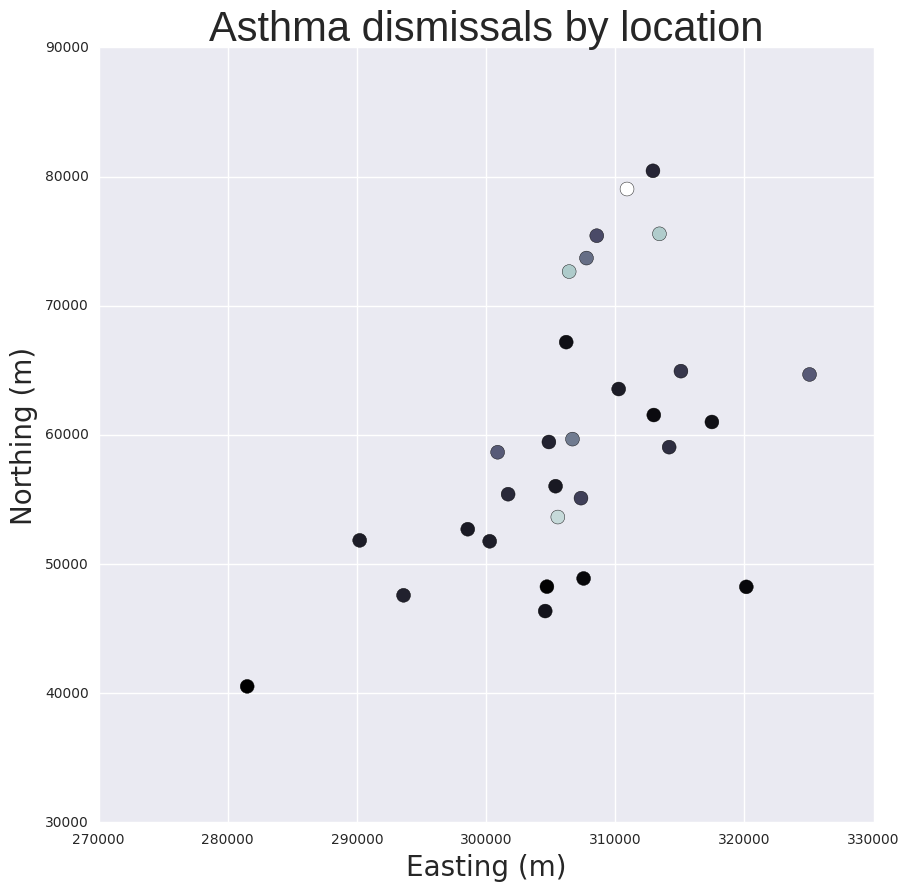

In [229]:
pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title('Asthma dismissals by location', fontsize=30)

Above we have graphed numbers of Asthma dismissals by location. The darker the color the higher the count. Each point is graphed based on the centroid of the zipcode it stems from.

## Semi-variogram 

#### Defining semi-variogram functions
Code from: https://github.com/fedhere/UInotebooks/blob/master/kriging/kriging_porosity.ipynb

In [230]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

#### Calculating numbers to use in the Semivariogram

In [232]:
# Calculating the maximum distance between two points
# Numbers visually gathered from data
y_dist=(80000-40000)
x_dist=(320000-280000)
maxd=math.sqrt(x_dist**2+y_dist**2)
print 'The maximum distance between points: %.2f' %maxd

The maximum distance between points: 56568.54


#### Plotting the semivariogram

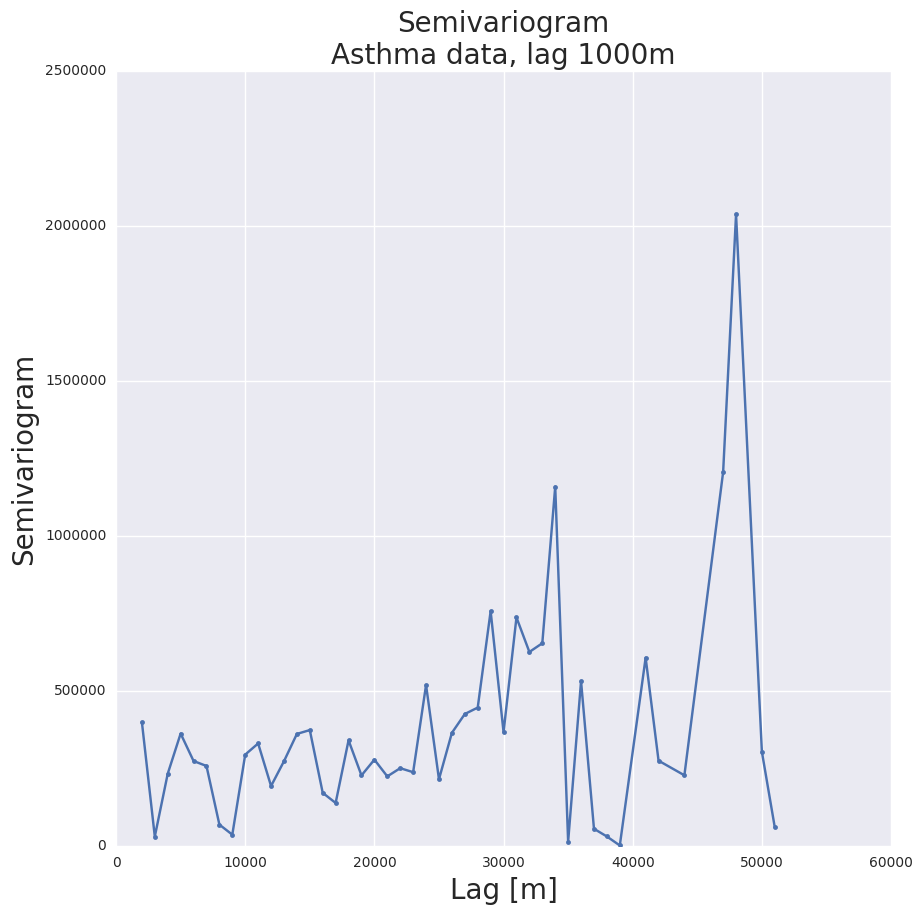

In [237]:
lag = 1000
mysv = SV(krigdata, np.arange(1, maxd, lag), 500)
pl.figure(figsize=(10,10))
pl.plot(mysv[0], mysv[1], '.-')
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Semivariogram\nAsthma data, lag %dm'%lag, fontsize=20) 

The topsy turvy nature of the semi-variogram indicates that there is no spatial correlation to be found.

In [ ]:
#@Review:
#comment on what's happening, what you infer? See solution.